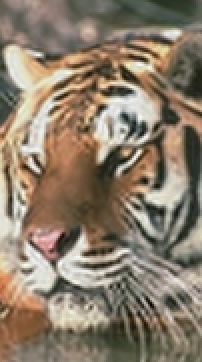

In [1]:
using Images,Distributions, JLD

test_image = "/Users/manvithaponnapati/RAISR/test_data/interpolated/test_image_2.jpg"
test_im = load(test_image)

In [2]:
@everywhere function hashkey(patch,weights_matrix,patchsize)
    gx,gy = imgradients(patch,KernelFactors.ando3)
    gx = reshape(gx,patchsize*patchsize,1)
    gy = reshape(gy,patchsize*patchsize,1)
    GT = transpose([gx gy])
   
    GTWG = GT*weights_matrix*transpose(GT)
    
    eigen_max = eigmax(GTWG)
    eigen_min = eigmin(GTWG)
    eigen_vector_max = eigvecs(GTWG)[:,1]
    eigen_vector_min = eigvecs(GTWG)[:,2]
    gradient_angle = atan2(eigen_vector_max[2],eigen_vector_max[1])
    if gradient_angle < 0
        gradient_angle = gradient_angle + pi
    end
    lamda = abs(sqrt(complex(eigen_max)))/Qstrength
    u =(sqrt(complex(eigen_max)) -  sqrt(complex(eigen_min)))/(sqrt(complex(eigen_max)) +  sqrt(complex(eigen_min)))/Qcoherence
    angle = floor(gradient_angle/pi*Qangle)

    if lamda < 0.0001
        strength = 1
    elseif lamda > 0.001
        strength = 3
    else
        strength = 2
    end

    u = abs(u)
    if u < 0.25
        coherence = 1
    elseif u > 0.5
        coherence = 3
    else
        coherence = 2
    end


    # Bound the output to the desired ranges
    if angle > 23
        angle = 23
    elseif angle <= 0
        angle = 1
    end
    angle = Int(angle)
    return angle,strength,coherence
end

In [3]:
learned_filters = load("learned_filters_partial_119.jld","filters")

24×3×3×4×121 Array{Float64,5}:
[:, :, 1, 1, 1] =
 6.82947e-5  6.83561e-5  6.71144e-5
 6.83087e-5  6.83394e-5  6.71871e-5
 6.82765e-5  6.83325e-5  6.71442e-5
 6.8279e-5   6.83324e-5  6.71154e-5
 6.83286e-5  6.83325e-5  6.70261e-5
 6.83767e-5  6.83375e-5  6.69985e-5
 6.81974e-5  6.83491e-5  6.68914e-5
 6.83515e-5  6.83299e-5  6.70734e-5
 6.82595e-5  6.83257e-5  6.70607e-5
 6.82712e-5  6.83353e-5  6.6955e-5 
 6.83367e-5  6.8334e-5   6.70273e-5
 6.82968e-5  6.83187e-5  6.7085e-5 
 6.8238e-5   6.83307e-5  6.71693e-5
 6.82696e-5  6.83558e-5  6.71745e-5
 6.83459e-5  6.8342e-5   6.72747e-5
 6.82913e-5  6.83309e-5  6.72236e-5
 6.82909e-5  6.83508e-5  6.70342e-5
 6.82915e-5  6.83362e-5  6.70348e-5
 6.82834e-5  6.83363e-5  6.70683e-5
 6.83063e-5  6.83466e-5  6.70688e-5
 6.83387e-5  6.83422e-5  6.7122e-5 
 6.82808e-5  6.83652e-5  6.70639e-5
 6.8275e-5   6.83643e-5  6.70607e-5
 0.0         0.0         0.0       

[:, :, 2, 1, 1] =
 6.83029e-5  6.83078e-5  6.70621e-5
 6.83454e-5  6.83094e-5  6.72572

In [4]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 11
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_partial_119.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance

724×404 Array{Float32,2}:
 0.143047  0.223348  0.223348  0.223348  …  0.225854  0.225854  0.225854
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.221371  0.379998  0.379998  0.379998     0.379829  0.379829  0.379829
 0.221371  0.379998  0.379998  0.379998  …  0.369726  0.369726  0.369726
 0.221371  0.379998  0.379998  0.379998     0.369726  0.369726  0.369726
 0.221371  0.379998  0.379998  0.379998     0.369726  0.369726  0.369726
 0.220364  0.377984  0.377984  0.377984     0.371703  0.371703  0.371703
 0.219357  0.376593  0.376593  0.376593     0.373296  0.373296  0.373296
 0.219357  0.376593  0.376593  0.376593  …  0.373296  0.373296  0.373296
 0.219357  0.376593  0.376593  0.376593     0.373296  0.373296  0.373296
 0.218974  0.375202  0.375202  0.375202     0.37465   0.37465   0.37465 
 ⋮                       

In [5]:
@time for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = ycbcr[1,row-5:row+5,col-5:col+5]
        gradientpatch = ycbcr[1,row-4:row+4,col-4:col+4]
        angle,strength,coherence = hashkey(gradientpatch,weights_matrix,9)
        pixeltype = ((row-start_index) % scaling_factor) * scaling_factor + ((col-start_index) % scaling_factor)
        patch_ravel = reshape(patch,patchsize*patchsize)
        upscaledHR[1,row,col] = (transpose(patch_ravel)*(learned_filters[angle,strength,coherence,pixeltype+1,:]))
    end
end

 21.276249 seconds (74.52 M allocations: 14.408 GiB, 9.38% gc time)


In [6]:
rmin = minimum(upscaledHR[1,:,:])
rmax = maximum(upscaledHR[1,:,:])

xGR = round((upscaledHR[1,:,:] -rmin) * (255 / rmax));
xGR

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Array{Float64,2}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] include_string(::Module, ::String, ::String) at /Users/manvithaponnapati/.julia/v0.6/Compat/src/Compat.jl:174
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/execute_request.jl:154
 [6] eventloop(::ZMQ.Socket) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[6], in expression starting on line 4


724×404 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0    0.0  …    0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  112.0  …  101.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  115.0     104.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  115.0     104.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  114.0     103.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  112.0     103.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  112.0  …  103.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  112.0     103.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  111.0     103.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                          ⋮    ⋱    

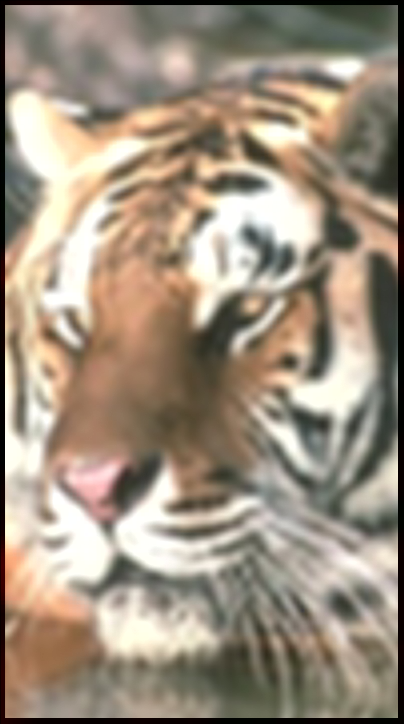

In [7]:
# Download Images from Ec2 Instance - Shut down instance
rupscaledHR = colorview(YCbCr,xGR,ycbcr[2,:,:],ycbcr[3,:,:])
# load("/Users/manvithaponnapati/RAISR/test_data/test_image_2.jpg")


# Bad performance on very pixelated images

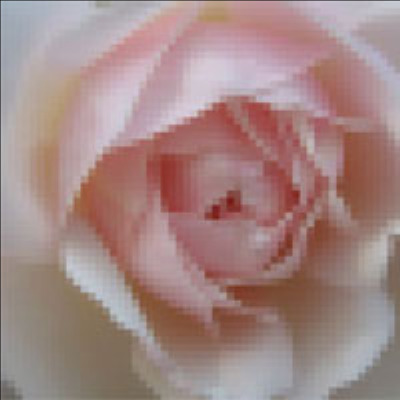

In [8]:
test_image = "/Users/manvithaponnapati/RAISR/test_data/interpolated/pixelrose.jpg"
test_im = load(test_image)

In [13]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 11
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_partial_119.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance

800×800 Array{Float32,2}:
 0.0991693  0.13521   0.181354  0.22413   …  0.234655  0.234655  0.234655
 0.13521    0.210658  0.299962  0.385899     0.405941  0.405941  0.405941
 0.181354   0.300969  0.413849  0.526729     0.579683  0.579683  0.579683
 0.225521   0.389303  0.52812   0.665966     0.752838  0.752838  0.752838
 0.215801   0.368857  0.516807  0.663366     0.748847  0.748847  0.748847
 0.208442   0.351778  0.50608   0.662743  …  0.745863  0.745863  0.745863
 0.214794   0.363859  0.513786  0.66472      0.739128  0.739128  0.739128
 0.220523   0.376323  0.522499  0.666074     0.732392  0.732392  0.732392
 0.217155   0.369204  0.515763  0.662706     0.73576   0.73576   0.73576 
 0.213403   0.362084  0.511004  0.658954     0.739128  0.739128  0.739128
 0.210419   0.358716  0.509027  0.659961  …  0.73576   0.73576   0.73576 
 0.208058   0.355348  0.509027  0.662322     0.733399  0.733399  0.733399
 0.212817   0.363859  0.513786  0.666697     0.733015  0.733015  0.733015
 ⋮          

In [14]:
@time for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = ycbcr[1,row-5:row+5,col-5:col+5]
        gradientpatch = ycbcr[1,row-4:row+4,col-4:col+4]
        angle,strength,coherence = hashkey(gradientpatch,weights_matrix,9)
        pixeltype = ((row-start_index) % scaling_factor) * scaling_factor + ((col-start_index) % scaling_factor)
        patch_ravel = reshape(patch,patchsize*patchsize)
        upscaledHR[1,row,col] = (transpose(patch_ravel)*(learned_filters[angle,strength,coherence,pixeltype+1,:]))
    end
end

 40.917427 seconds (163.30 M allocations: 31.835 GiB, 11.87% gc time)


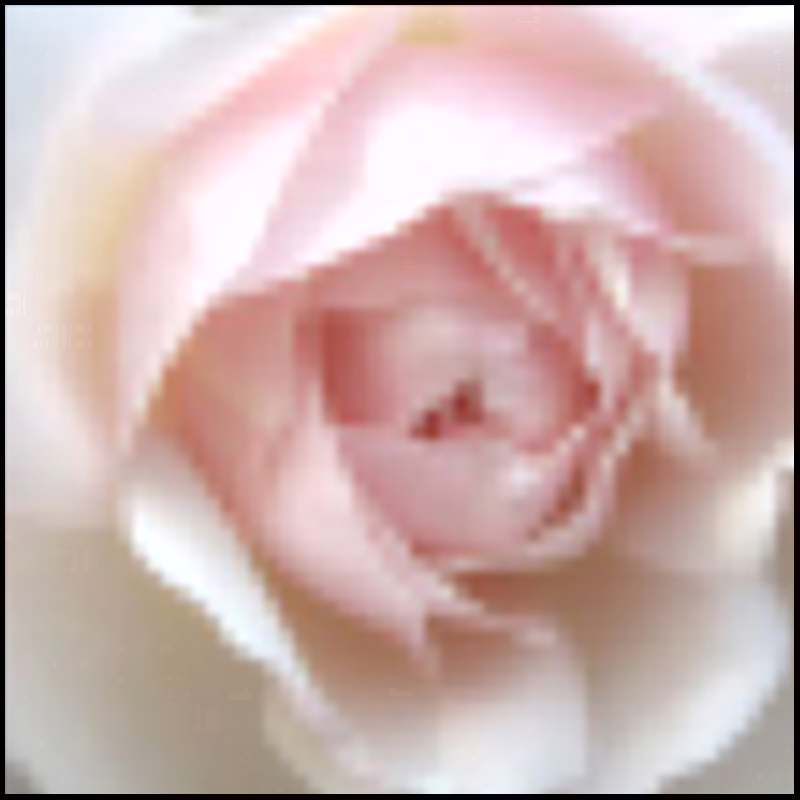

In [15]:
rmin = minimum(upscaledHR[1,:,:])
rmax = maximum(upscaledHR[1,:,:])

xGR = round.((upscaledHR[1,:,:] -rmin) * (255 / rmax));
rupscaledHR = colorview(YCbCr,xGR,ycbcr[2,:,:],ycbcr[3,:,:])

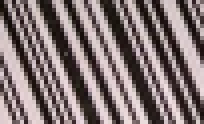

In [20]:
test_image = "/Users/manvithaponnapati/RAISR/test_data/barcode.png"
test_im = load(test_image)

In [21]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 11
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_partial_119.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance

@time for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = ycbcr[1,row-5:row+5,col-5:col+5]
        gradientpatch = ycbcr[1,row-4:row+4,col-4:col+4]
        angle,strength,coherence = hashkey(gradientpatch,weights_matrix,9)
        pixeltype = ((row-start_index) % scaling_factor) * scaling_factor + ((col-start_index) % scaling_factor)
        patch_ravel = reshape(patch,patchsize*patchsize)
        upscaledHR[1,row,col] = (transpose(patch_ravel)*(learned_filters[angle,strength,coherence,pixeltype+1,:]))
    end
end

  4.998417 seconds (24.23 M allocations: 4.805 GiB, 14.15% gc time)


In [23]:
rmin = minimum(upscaledHR[1,:,:])
rmax = maximum(upscaledHR[1,:,:])

xGR = round.((upscaledHR[1,:,:] -rmin) * (255 / rmax));
rupscaledHR = colorview(YCbCr,xGR,ycbcr[2,:,:],ycbcr[3,:,:])

save("/Users/manvithaponnapati/RAISR/test_data/learntbarcode.png",rupscaledHR)